In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import cluster, datasets, mixture

from sklearn.metrics import silhouette_score,davies_bouldin_score,calinski_harabasz_score

from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN

from sklearn.manifold import TSNE

In [2]:
data = pd.read_csv('../../data/modelers_data.csv')

In [3]:
# podmiana złej rozdzielczości
mask = data.resolution_width <= data.resolution_height
data.loc[mask,["resolution_width","resolution_height"]] = data.loc[mask,["resolution_height","resolution_width"]].values


In [5]:
data.loc[data.resolution_width <= data.resolution_height]

,index,brand,Model,Price,Rating,processor_brand,processor_tier,num_cores,num_threads,ram_memory,...,secondary_storage_type,secondary_storage_capacity,gpu_brand,gpu_type,is_touch_screen,display_size,resolution_width,resolution_height,OS,year_of_warranty


In [6]:
data.head(3)

,index,brand,Model,Price,Rating,processor_brand,processor_tier,num_cores,num_threads,ram_memory,...,secondary_storage_type,secondary_storage_capacity,gpu_brand,gpu_type,is_touch_screen,display_size,resolution_width,resolution_height,OS,year_of_warranty
0,949,msi,MSI Modern 15 B7M-072IN Laptop (Ryzen 5 7530U/...,43990,53,amd,ryzen 5,6,12,8,...,No secondary storage,0,amd,integrated,False,15.6,1920,1080,windows,1
1,584,msi,MSI Prestige 16 A13UCX-250IN Laptop (13th Gen ...,119990,73,intel,core i7,14,20,16,...,No secondary storage,0,nvidia,dedicated,False,16.0,2560,1600,windows,2
2,937,acer,Acer Aspire 7 A715-75G Gaming Laptop (10th Gen...,45990,59,intel,core i5,4,8,8,...,No secondary storage,0,nvidia,dedicated,False,15.6,1920,1080,windows,1


In [7]:
#   Column                      Non-Null Count  Dtype       Nulls                  Kodowanie                                   Blady
# ---  ------                      --------------  -----    -------                -------                                     ------
#  1   brand                       693 non-null    object                           grupowanie,
#  2   Model                       693 non-null    object   useless                 odrzucic
#  3   Price                       693 non-null    int64   
#  4   Rating                      693 non-null    int64  
#  5   processor_brand             693 non-null    object   other                   oh
#  6   processor_tier              693 non-null    object   other                   numerycznie
#  7   num_cores                   693 non-null    int64  
#  8   num_threads                 693 non-null    int64  
#  9   ram_memory                  693 non-null    int64  
#  10  primary_storage_type        693 non-null    object                           oh,bin ?             676/17
#  11  primary_storage_capacity    693 non-null    int64  
#  12  secondary_storage_type      693 non-null    object   No secondary storage    oh,bin ? odrzucic, bo mamy secondary_storage_capacity==0   10/683
#  13  secondary_storage_capacity  693 non-null    int64  
#  14  gpu_brand                   693 non-null    object                           oh
#  15  gpu_type                    693 non-null    object                           apple ma apple, reszta binary
#  16  is_touch_screen             693 non-null    bool   
#  17  display_size                693 non-null    float64
#  18  resolution_width            693 non-null    int64  
#  19  resolution_height           693 non-null    int64                                                                       6 recordow ma większe rh od rw (to są bledy)
#  20  OS                          693 non-null    object   other                   oh , stosunek windowsa do reszty 647/46
#  21  year_of_warranty            693 non-null    object   No information          numerycznie, kolumna na brak informacji

# Preprocessing

 KTÓRE KOLUMNY POWINNY ZACHOWAĆ NIEZMIENIONE WARTOŚCI??? KTÓRYCH NIE TYKAMY ???

In [8]:
data_copy = data.copy()

In [9]:
# oh dla []'processor_brand','OS','gpu_brand','gpu_type'] oraz dla brand ,ale tylko 6 najczęstszych wartości
diff1 = pd.get_dummies(data_copy[['processor_brand','OS','gpu_brand','gpu_type']],dtype='int')
brands_to_keep = ['hp' , 'lenovo' , 'asus','dell','msi','acer','apple']
data_copy['brand'] = data_copy['brand'].apply(lambda x: x if x in brands_to_keep else 'other')
diff2 = pd.get_dummies(data_copy[['brand']],dtype='int')
data_copy_2 = data_copy.copy()
data_copy_2 = data_copy_2.drop(['index','Model','brand','OS','processor_brand','processor_tier','gpu_brand','gpu_type'],axis=1)
df1 = pd.concat([data_copy_2,diff1,diff2],axis=1)
df1.is_touch_screen = df1.is_touch_screen + 0
df1.primary_storage_type = (df1.primary_storage_type=='SSD') + 0


In [10]:
df1.head(2)

,Price,Rating,num_cores,num_threads,ram_memory,primary_storage_type,primary_storage_capacity,secondary_storage_type,secondary_storage_capacity,is_touch_screen,...,gpu_type_dedicated,gpu_type_integrated,brand_acer,brand_apple,brand_asus,brand_dell,brand_hp,brand_lenovo,brand_msi,brand_other
0,43990,53,6,12,8,1,512,No secondary storage,0,0,...,0,1,0,0,0,0,0,0,1,0
1,119990,73,14,20,16,1,1024,No secondary storage,0,0,...,1,0,0,0,0,0,0,0,1,0


# Rozkład ceny

Zarówno TSNE jak i DBSCAN działają inaczej po użyciuu log() na kolumnie z cenami

Text(0.5, 1.0, 'Rozkład log(price)')

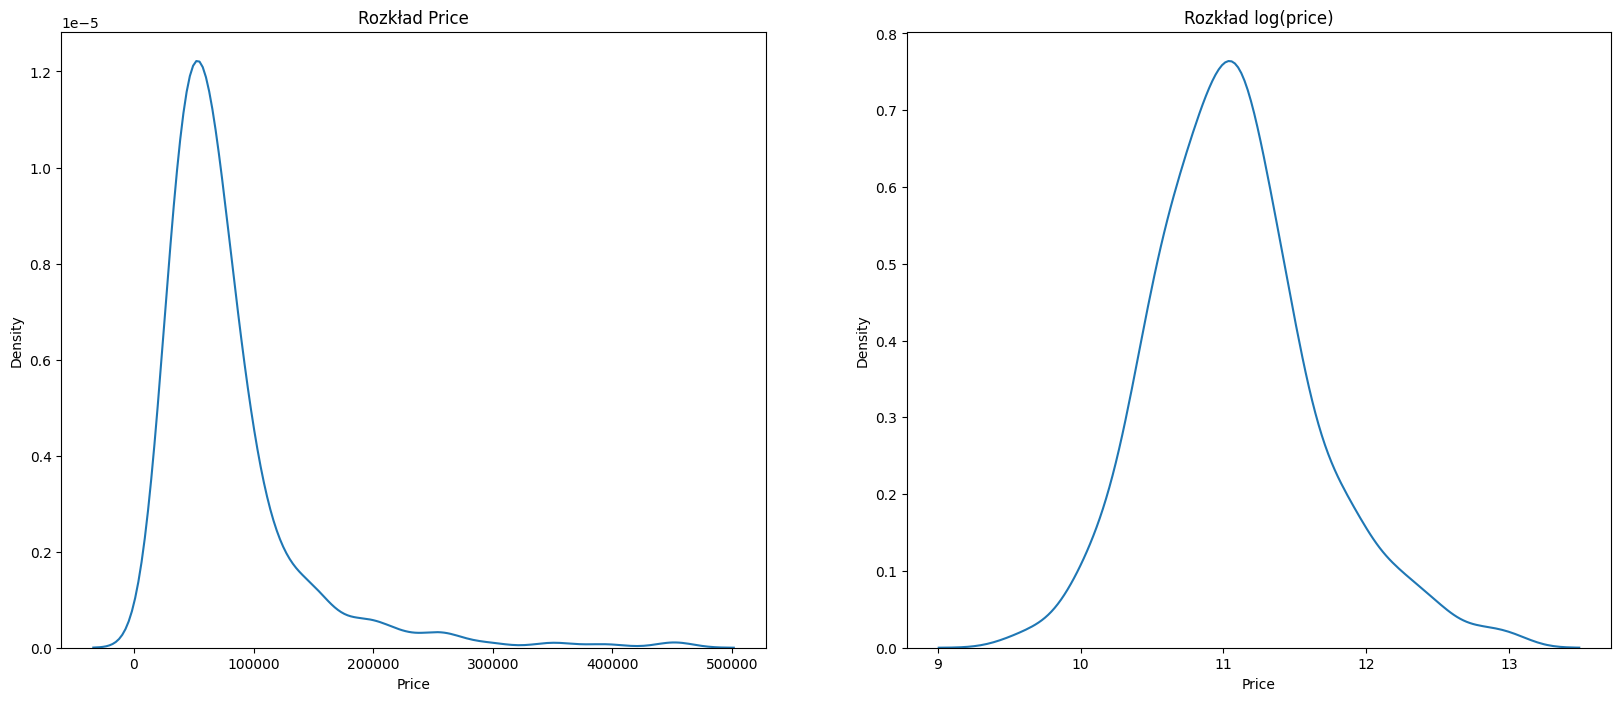

In [11]:
figure,ax = plt.subplots(1,2,figsize=(20,8))
ax = ax.flatten()
sns.kdeplot(x=data.Price,ax=ax[0])
ax[0].set_title("Rozkład Price")
sns.kdeplot(x=np.log(data.Price),ax=ax[1])
ax[1].set_title("Rozkład log(price)")


# Processor Tier

In [12]:
data.processor_tier.value_counts()

processor_tier
core i5         231
core i7         113
ryzen 5         100
core i3          95
ryzen 7          59
celeron          25
core i9          23
ryzen 3          21
ryzen 9           8
other             7
m3                6
m2                3
core ultra 7      1
pentium           1
Name: count, dtype: int64

In [13]:
# ryzen x == core ix
# celeron == core i3
# m1 == core i5
# m2 == core i7
# core ultra 7 == core i7 | core i9 ?
# pentium == core i5

In [14]:
A = data.processor_tier
A[A=='celeron'] = 'core i3'
A[A=='pentium'] = 'core i5'
A[A=='m1'] = 'core i5'
A[A=='m2'] = 'core i7'
mask_other_processor_tier = A=='other'
A[A=='other'] = '0'
A = A.apply(lambda x : int(re.findall(r'\d+', x)[0]))

C:\Users\jancw\AppData\Local\Temp\ipykernel_4232\2374467150.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A[A=='celeron'] = 'core i3'
C:\Users\jancw\AppData\Local\Temp\ipykernel_4232\2374467150.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A[A=='pentium'] = 'core i5'
C:\Users\jancw\AppData\Local\Temp\ipykernel_4232\2374467150.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A[A=='m1'] = 'core i5'
C:\Users\jancw\AppData\L

In [15]:
df1['processor_tier'] = A
df1['processor_type_other'] = mask_other_processor_tier + 0

# year_of_warranty

In [16]:
mask_year_of_war_no =df1.year_of_warranty=='No information'
df1.loc[mask_year_of_war_no,['year_of_warranty']] = 0
df1['year_of_warranty'] = df1['year_of_warranty'].apply(lambda x : int(x))
df1['year_of_warranty_other'] = mask_year_of_war_no + 0

In [17]:
df1.head()

,Price,Rating,num_cores,num_threads,ram_memory,primary_storage_type,primary_storage_capacity,secondary_storage_type,secondary_storage_capacity,is_touch_screen,...,brand_apple,brand_asus,brand_dell,brand_hp,brand_lenovo,brand_msi,brand_other,processor_tier,processor_type_other,year_of_warranty_other
0,43990,53,6,12,8,1,512,No secondary storage,0,0,...,0,0,0,0,0,1,0,5,0,0
1,119990,73,14,20,16,1,1024,No secondary storage,0,0,...,0,0,0,0,0,1,0,7,0,0
2,45990,59,4,8,8,1,512,No secondary storage,0,0,...,0,0,0,0,0,0,0,5,0,0
3,449990,89,24,32,4,1,2048,No secondary storage,0,0,...,0,0,0,0,0,1,0,9,0,0
4,41490,45,8,8,8,1,512,No secondary storage,0,0,...,0,0,0,0,0,0,0,3,0,0


# secondary_storage_type

- opcja 1: zrezygnować z 'secondary_storage_type' na rzecz 'secondary_storage_capacity', bo ta kolumna wynosi 0 gdy nie ma drugiego dysku
- opcja 2: zostawić 'secondary_storage_type' i tam gdzie nie ma dawać 0

In [18]:
# opcja 1
df1 = df1.drop('secondary_storage_type',axis=1)
# opcja 2
# df1['secondary_storage_type'] = (df1['secondary_storage_type']=="HDD") + 0 

In [19]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693 entries, 0 to 692
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Price                       693 non-null    int64  
 1   Rating                      693 non-null    int64  
 2   num_cores                   693 non-null    int64  
 3   num_threads                 693 non-null    int64  
 4   ram_memory                  693 non-null    int64  
 5   primary_storage_type        693 non-null    int32  
 6   primary_storage_capacity    693 non-null    int64  
 7   secondary_storage_capacity  693 non-null    int64  
 8   is_touch_screen             693 non-null    int32  
 9   display_size                693 non-null    float64
 10  resolution_width            693 non-null    int64  
 11  resolution_height           693 non-null    int64  
 12  year_of_warranty            693 non-null    int64  
 13  processor_brand_amd         693 non

# Pierwsze modele

In [20]:
# funkcje do wykresów z zajęć
def count_wcss_scores(X, k_max):
    #  WCSS = within-cluster sum of squares
    scores = []
    for k in range(1, k_max+1):
        kmeans = KMeans(n_clusters=k, random_state=101)
        kmeans.fit(X)
        wcss = kmeans.score(X) * -1 # score returns -WCSS
        scores.append(wcss)
    return scores

# A w praktyce wygląda to tak:
def count_clustering_scores(X, cluster_num, model, score_fun):
    # Napiszmy tę funkcje tak ogólnie, jak to możliwe. 
    # Zwróćcie uwagę na przekazanie obiektów typu callable: model i score_fun.
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k,random_state= 101)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores
    
def metrics_plots(X,max_k=10):

    score = []
    score_kmeans_s = []
    score_kmeans_c = []
    score_kmeans_d = []

    for k in range(2, max_k):
        kmeans = KMeans(n_clusters=k, random_state= 101)
        predictions = kmeans.fit_predict(X)
        # Calculate cluster validation metrics and append to lists of metrics
        score.append(kmeans.score(X))
        score_kmeans_s.append(silhouette_score(X, kmeans.labels_, metric='euclidean'))
        score_kmeans_c.append(calinski_harabasz_score(X, kmeans.labels_))
        score_kmeans_d.append(davies_bouldin_score(X, predictions))

    list_scores = [score, score_kmeans_s, score_kmeans_c, score_kmeans_d] 
    # Elbow Method plot
    list_title = ['Within-cluster sum of squares', 'Silhouette Score', 'Calinski Harabasz', 'Davies Bouldin'] 
    for i in range(len(list_scores)):
        x_ticks = list(range(2, len(list_scores[i]) + 2))
        plt.plot(x_ticks, list_scores[i], 'bx-')
        plt.xlabel('k')
        plt.ylabel(list_title[i])
        plt.title('Optimal k')
        plt.show()

Text(0.5, 1.0, 'Metoda silhouette')

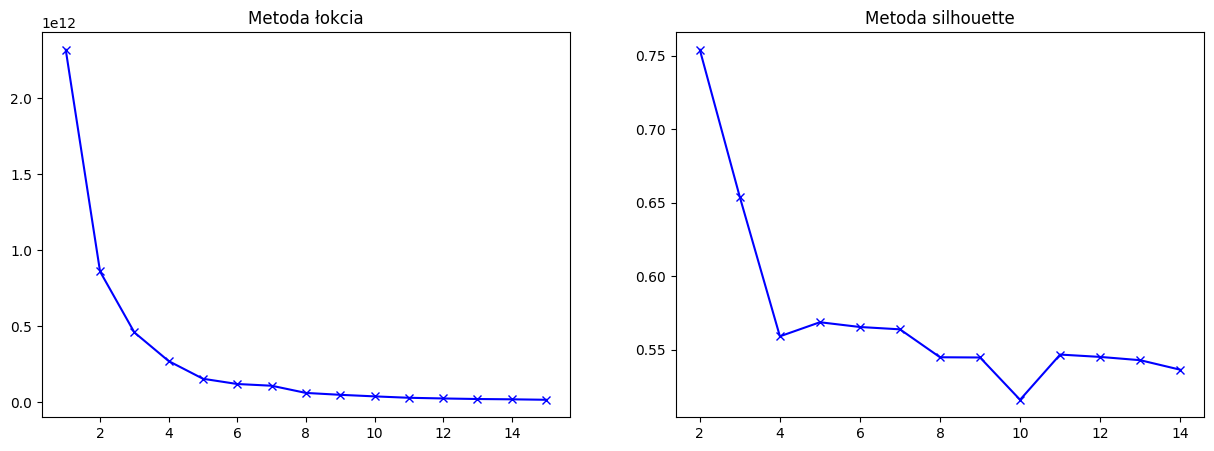

In [29]:
fig, axis = plt.subplots(1,2,figsize=(15,5))
wcss_vec = count_wcss_scores(df1, 15)
x_ticks = list(range(1, len(wcss_vec) + 1))
axis[0].plot(x_ticks, wcss_vec, 'bx-')
axis[0].set_title("Metoda łokcia")
cluster_num_seq = range(2, 15) # Niektóre metryki nie działają gdy mamy tylko jeden klaster
silhouette_vec = count_clustering_scores(df1, cluster_num_seq, KMeans, silhouette_score)
axis[1].plot(cluster_num_seq, silhouette_vec, 'bx-')
axis[1].set_title("Metoda silhouette")

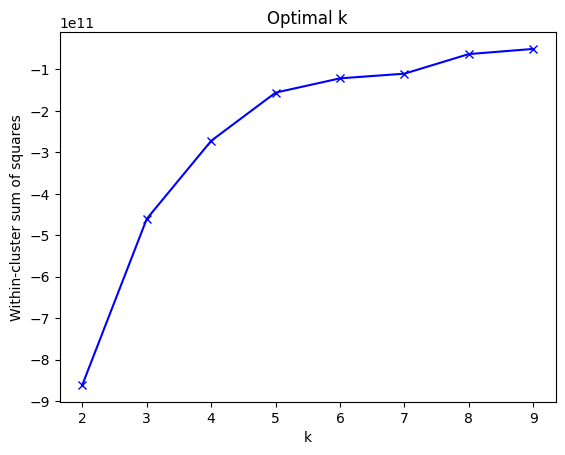

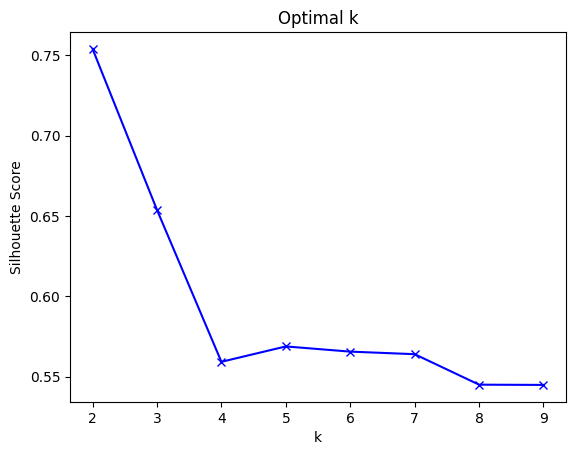

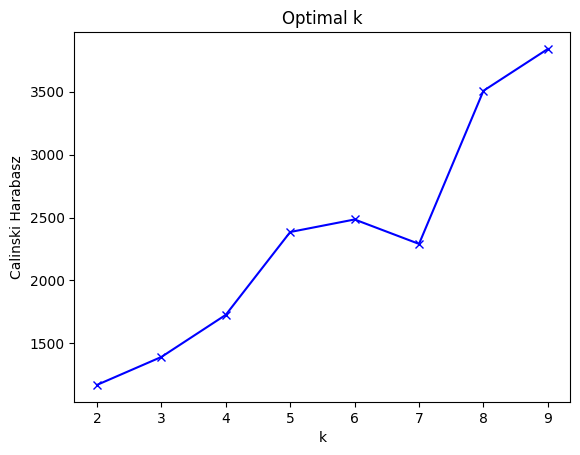

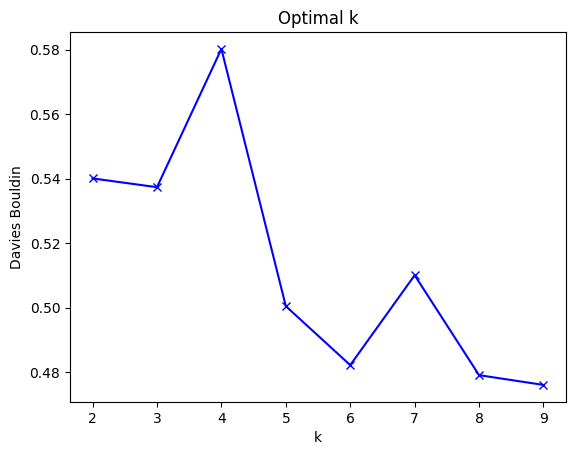

In [31]:
metrics_plots(df1,max_k=10)

# AgglomerativeClustering

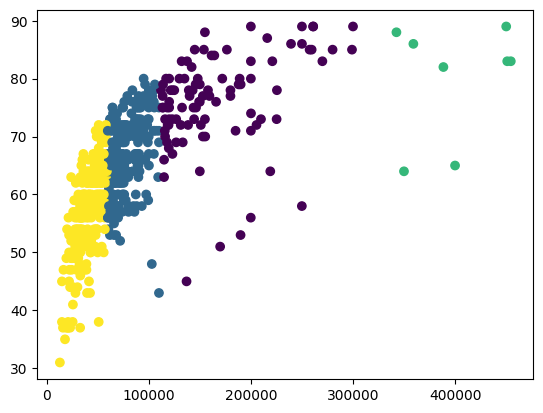

In [32]:
model_matrix = df1.values
model = AgglomerativeClustering(n_clusters=4)
y_aggc = model.fit_predict(model_matrix)
plt.scatter(model_matrix[:, 0], model_matrix[:, 1], c=y_aggc, cmap='viridis')
plt.show()

# KMeans

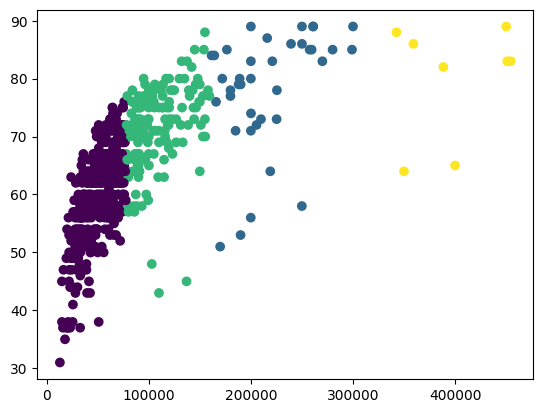

In [33]:
model_matrix = df1.values
model_kmeans = KMeans(n_clusters=4)
y_km = model_kmeans.fit_predict(df1)
plt.scatter(model_matrix[:, 0], model_matrix[:, 1], c=y_km, cmap='viridis')
# centers = model_kmeans.cluster_centers_
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.75)
plt.show()

# DBSCAN 

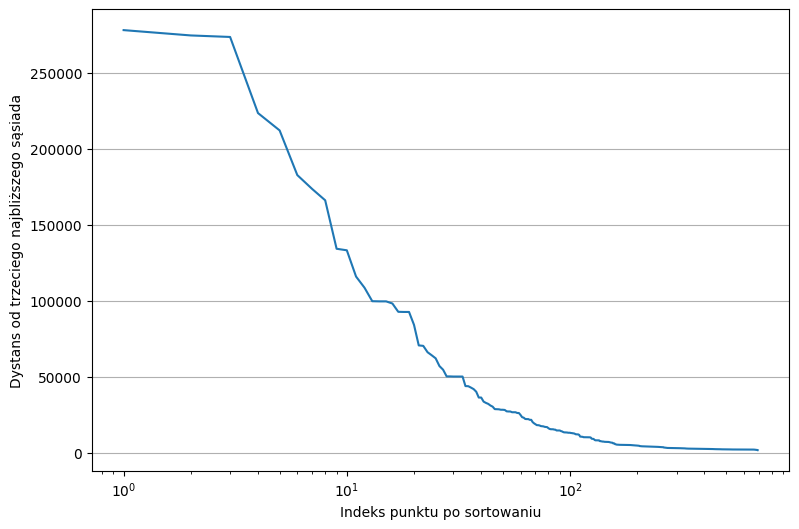

In [34]:
model_matrix = df1.values
minPts = model_matrix.shape[1]
nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=minPts).fit(model_matrix)
distances, indices = nbrs.kneighbors(model_matrix)
distanceDec = sorted(distances[:,minPts-1], reverse=True)
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)

plt.xlabel('Indeks punktu po sortowaniu')
plt.ylabel('Dystans od trzeciego najbliższego sąsiada')
ax1.plot(list(range(1,model_matrix.shape[0]+1)), distanceDec)

plt.xscale('log')
plt.grid(axis='y')

plt.show()

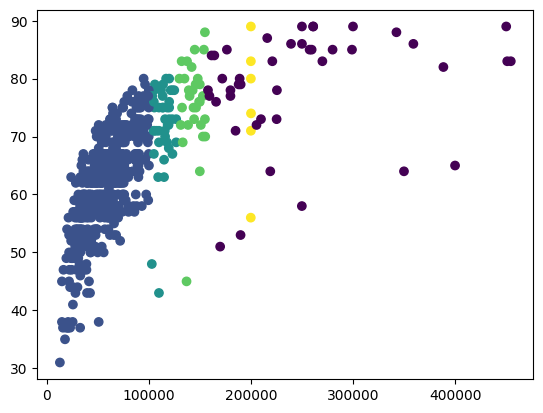

In [35]:
model_dbscan = DBSCAN(eps=2800)
y_dbscan = model_dbscan.fit_predict(model_matrix)
plt.scatter(model_matrix[:, 0], model_matrix[:, 1], c=y_dbscan, cmap='viridis')
plt.show()


# DBSCAN po zlogarytmowaniu cen

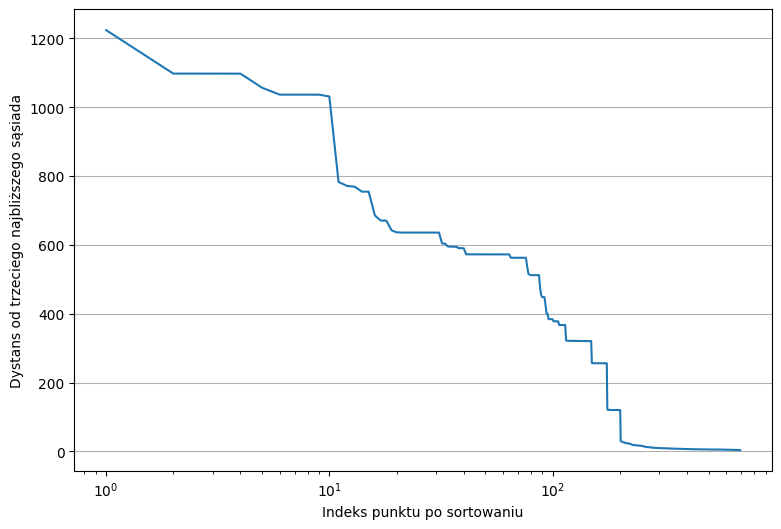

In [36]:
model_matrix = df1.values
model_matrix[:,0] = np.log(model_matrix[:,0])
minPts = model_matrix.shape[1]
nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=minPts).fit(model_matrix)
distances, indices = nbrs.kneighbors(model_matrix)
distanceDec = sorted(distances[:,minPts-1], reverse=True)
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)

plt.xlabel('Indeks punktu po sortowaniu')
plt.ylabel('Dystans od trzeciego najbliższego sąsiada')
ax1.plot(list(range(1,model_matrix.shape[0]+1)), distanceDec)

plt.xscale('log')
plt.grid(axis='y')

plt.show()

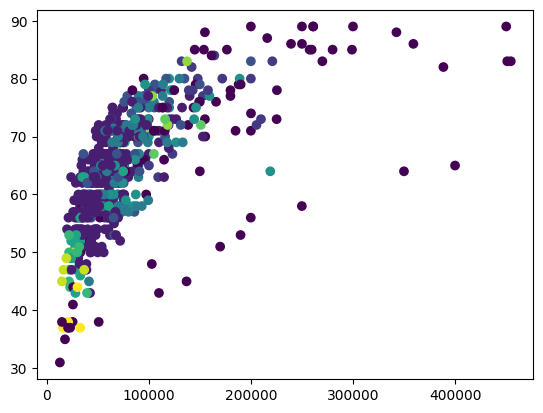

In [37]:

model_dbscan = DBSCAN(eps=10)
y_dbscan_log = model_dbscan.fit_predict(model_matrix)
plt.scatter(np.exp(model_matrix[:, 0]), model_matrix[:, 1], c=y_dbscan_log, cmap='viridis')
plt.show()



# Gaussian Mixture Models

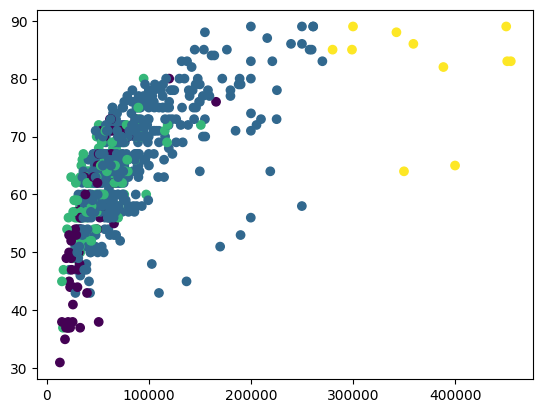

In [38]:
model_matrix = df1.values
model_gmm = mixture.GaussianMixture(n_components=4, covariance_type="full")
y_gmm = model_gmm.fit_predict(model_matrix)
plt.scatter(model_matrix[:, 0], model_matrix[:, 1], c=y_gmm, cmap='viridis')
plt.show()

# Wykresy wyników

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 693 samples in 0.000s...
[t-SNE] Computed neighbors for 693 samples in 0.058s...
[t-SNE] Computed conditional probabilities for sample 693 / 693
[t-SNE] Mean sigma: 3.760916
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.815380
[t-SNE] KL divergence after 1000 iterations: 0.198779


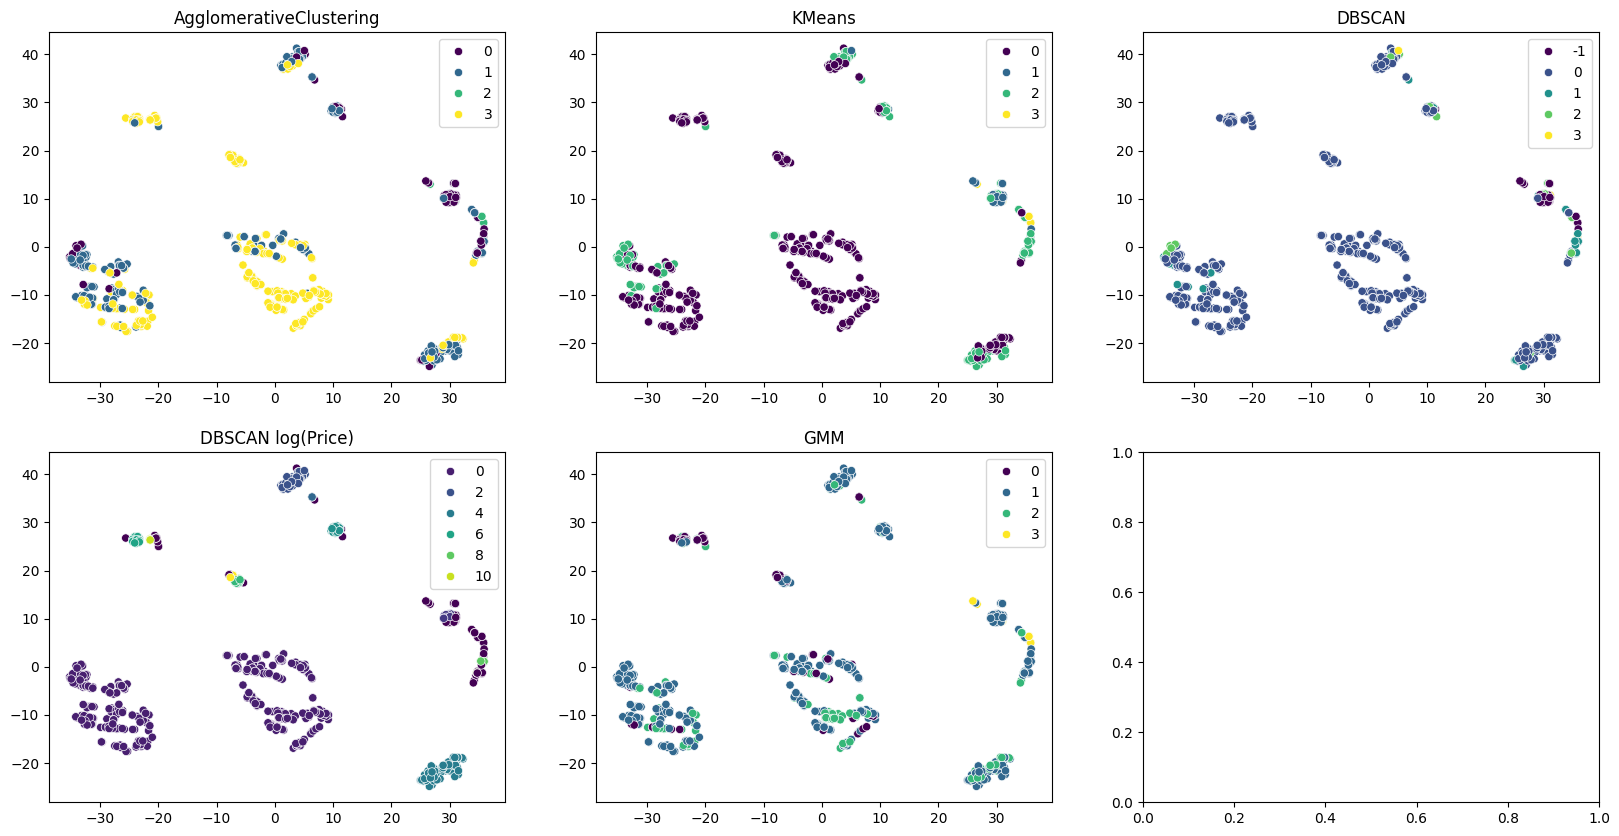

In [39]:
df1_copy = df1.copy()
tSNE = TSNE(random_state=60, verbose=1,n_iter=1000)
df1_copy['Price'] = np.log(df1_copy['Price'] )
digits_proj = tSNE.fit_transform(df1_copy)

figure,ax = plt.subplots(2,3,figsize=(20,10))
ax = ax.flatten()
predictions = [y_aggc,y_km,y_dbscan,y_dbscan_log,y_gmm]
predictions_title = ['AgglomerativeClustering','KMeans','DBSCAN','DBSCAN log(Price)','GMM']
for i in range(len(predictions)):
    sns.scatterplot(x=digits_proj[:,0], y=digits_proj[:,1],hue=predictions[i],palette='viridis',ax=ax[i])
    ax[i].set_title(predictions_title[i])
plt.show()

# Inne pomysły na transformacje

dalej mamy parę kolumn ,których wartości przyjmują relatywnie duże wartości co w kontraście z 0,1 z ohencodingu może być niekorzystne:
 - primary_storage_capacity - log2
 - secondary_storage_capacity - log2
 - resolution_width - cos
 - resolution_height - cos
 - Price - log (NIE PODLEGA WĄTPLIWOŚCI ??)
 - Rating - przeskalować do [0,1]
 - display_size - cos

 KTÓRE KOLUMNY POWINNY ZACHOWAĆ NIEZMIENIONE WARTOŚCI???

1. primary_storage_capacity -> np.log2(df1.primary_storage_capacity)

Text(0.5, 1.0, 'Rozkład log(primary_storage_capacity)')

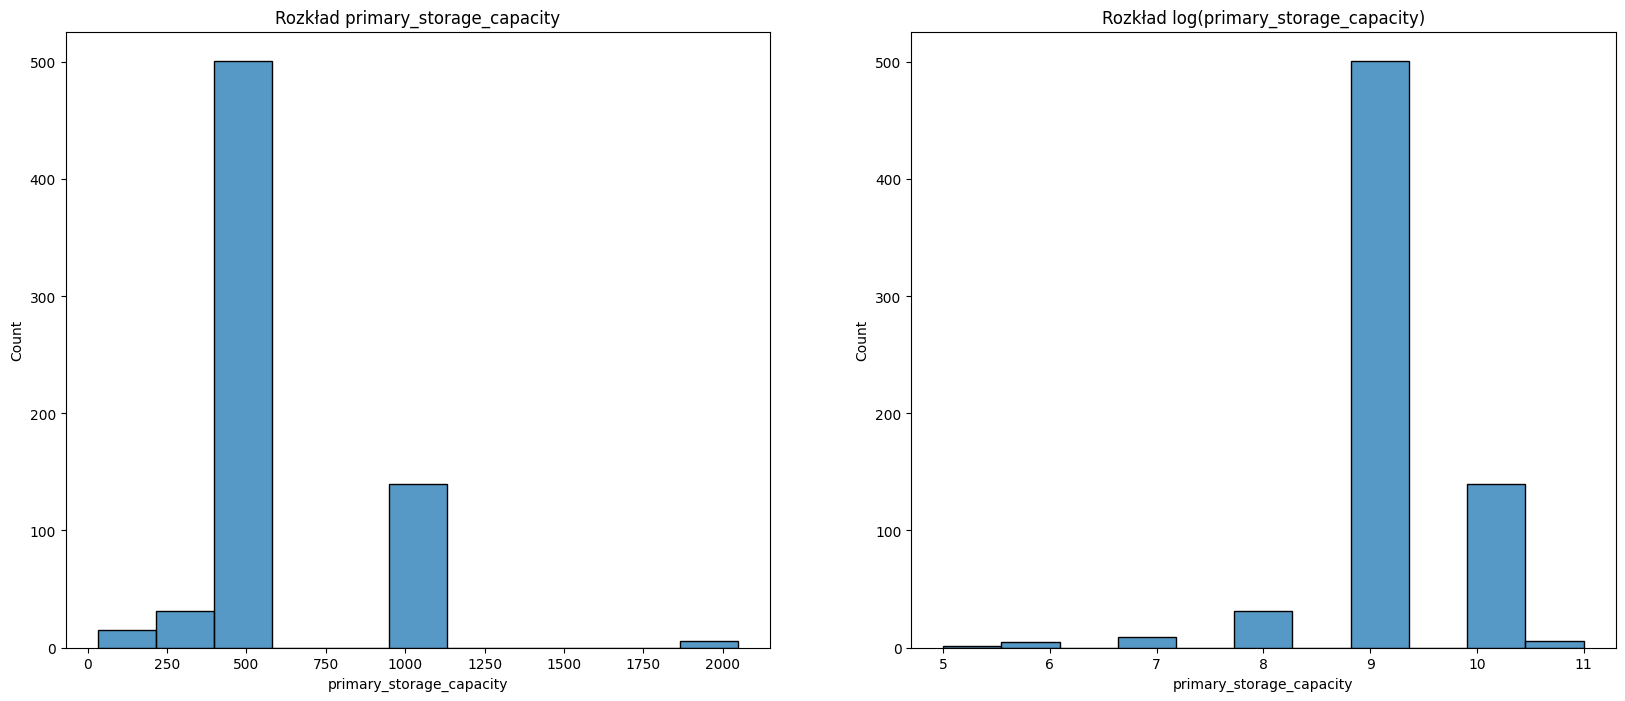

In [90]:
figure,ax = plt.subplots(1,2,figsize=(20,8))
ax = ax.flatten()
sns.histplot(x=df1.primary_storage_capacity,ax=ax[0])
ax[0].set_title("Rozkład primary_storage_capacity")
sns.histplot(x=np.log2(df1.primary_storage_capacity),ax=ax[1])
ax[1].set_title("Rozkład log(primary_storage_capacity)")


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 693 samples in 0.000s...
[t-SNE] Computed neighbors for 693 samples in 0.052s...
[t-SNE] Computed conditional probabilities for sample 693 / 693
[t-SNE] Mean sigma: 3.371486
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.329464
[t-SNE] KL divergence after 1000 iterations: 0.221981


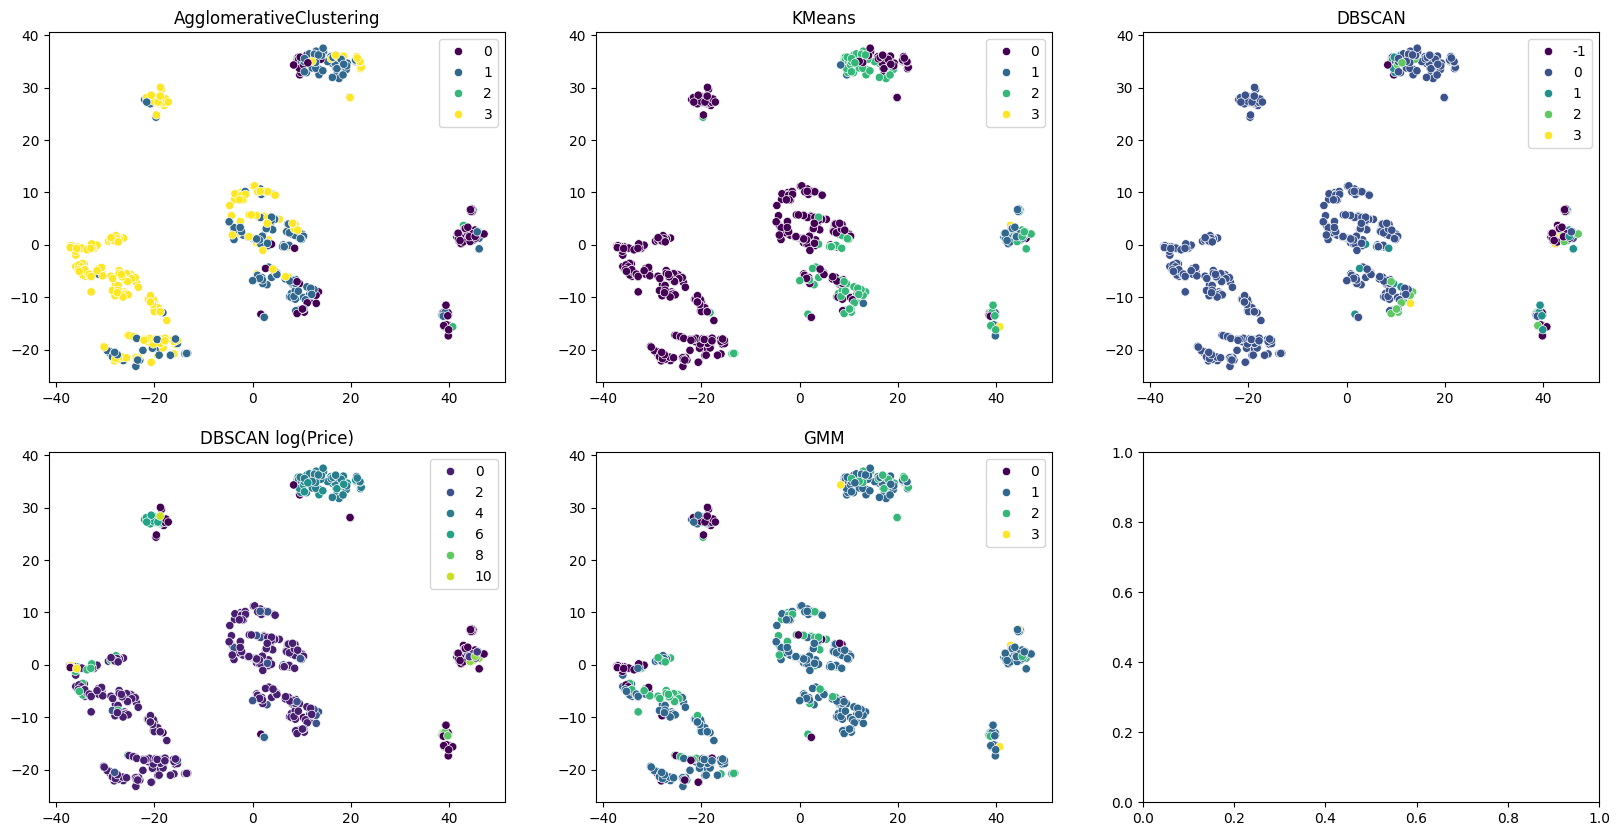

In [72]:
df1_copy = df1.copy()
tSNE = TSNE(random_state=60, verbose=1,n_iter=1000)
df1_copy['Price'] = np.log(df1_copy['Price'] )
df1_copy['primary_storage_capacity'] = np.log2(df1.primary_storage_capacity)
digits_proj = tSNE.fit_transform(df1_copy)

figure,ax = plt.subplots(2,3,figsize=(20,10))
ax = ax.flatten()
predictions = [y_aggc,y_km,y_dbscan,y_dbscan_log,y_gmm]
predictions_title = ['AgglomerativeClustering','KMeans','DBSCAN','DBSCAN log(Price)','GMM']
for i in range(len(predictions)):
    sns.scatterplot(x=digits_proj[:,0], y=digits_proj[:,1],hue=predictions[i],palette='viridis',ax=ax[i])
    ax[i].set_title(predictions_title[i])
plt.show()

2. secondary_storage_capacity ->  np.log2(df1.primary_storage_capacity) i -inf na 0

C:\Users\jancw\AppData\Local\Temp\ipykernel_4232\2622908972.py:4: RuntimeWarning: divide by zero encountered in log2
  df1_copy['secondary_storage_capacity'] = df1_copy['secondary_storage_capacity'].apply(lambda x : max(0,np.log2(x)))


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 693 samples in 0.003s...
[t-SNE] Computed neighbors for 693 samples in 0.050s...
[t-SNE] Computed conditional probabilities for sample 693 / 693
[t-SNE] Mean sigma: 3.749144
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.658855
[t-SNE] KL divergence after 1000 iterations: 0.204783


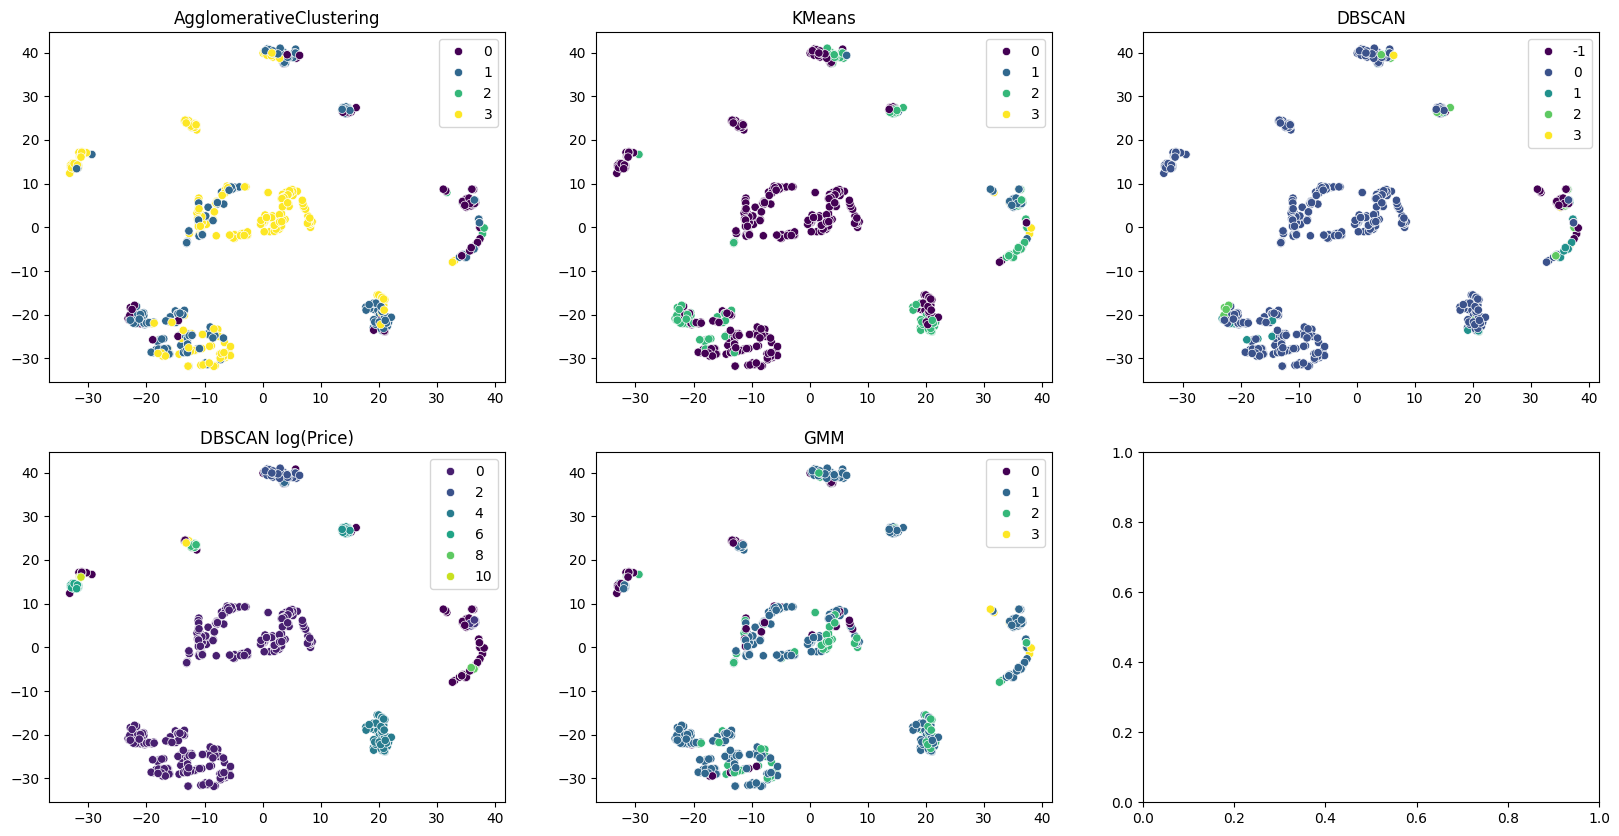

In [73]:
df1_copy = df1.copy()
df1_copy['Price'] = np.log(df1_copy['Price'] )
# df1_copy['primary_storage_capacity'] = np.log2(df1.primary_storage_capacity)
df1_copy['secondary_storage_capacity'] = df1_copy['secondary_storage_capacity'].apply(lambda x : max(0,np.log2(x)))

tSNE = TSNE(random_state=60, verbose=1,n_iter=1000)
digits_proj = tSNE.fit_transform(df1_copy)

figure,ax = plt.subplots(2,3,figsize=(20,10))
ax = ax.flatten()
predictions = [y_aggc,y_km,y_dbscan,y_dbscan_log,y_gmm]
predictions_title = ['AgglomerativeClustering','KMeans','DBSCAN','DBSCAN log(Price)','GMM']
for i in range(len(predictions)):
    sns.scatterplot(x=digits_proj[:,0], y=digits_proj[:,1],hue=predictions[i],palette='viridis',ax=ax[i])
    ax[i].set_title(predictions_title[i])
plt.show()

3. resolution -> log

Text(0.5, 1.0, 'res height log')

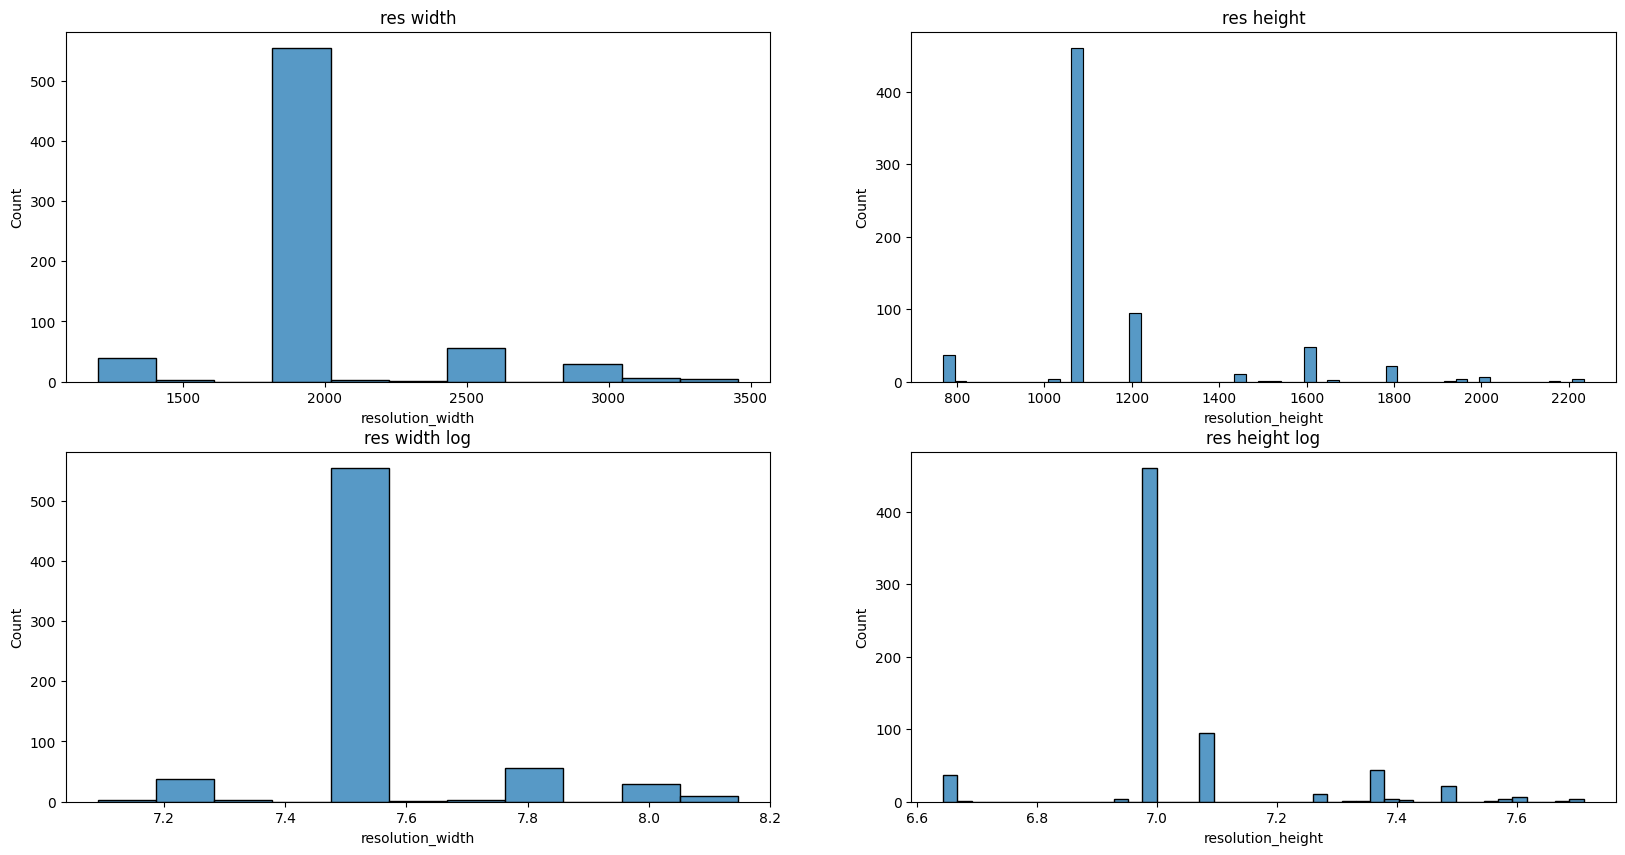

In [79]:
figure,ax = plt.subplots(2,2,figsize=(20,10))
ax = ax.flatten()
sns.histplot((df1.resolution_width),ax=ax[0])
sns.histplot((df1.resolution_height),ax=ax[1])
sns.histplot(np.log(df1.resolution_width),ax=ax[2])
sns.histplot(np.log(df1.resolution_height),ax=ax[3])
ax[0].set_title("res width")
ax[1].set_title("res height")
ax[2].set_title("res width log")
ax[3].set_title("res height log")

C:\Users\jancw\AppData\Local\Temp\ipykernel_4232\2829613148.py:4: RuntimeWarning: divide by zero encountered in log2
  df1_copy['secondary_storage_capacity'] = df1_copy['secondary_storage_capacity'].apply(lambda x : max(0,np.log2(x)))


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 693 samples in 0.001s...
[t-SNE] Computed neighbors for 693 samples in 0.052s...
[t-SNE] Computed conditional probabilities for sample 693 / 693
[t-SNE] Mean sigma: 2.654819
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.119011
[t-SNE] KL divergence after 1000 iterations: 0.294184


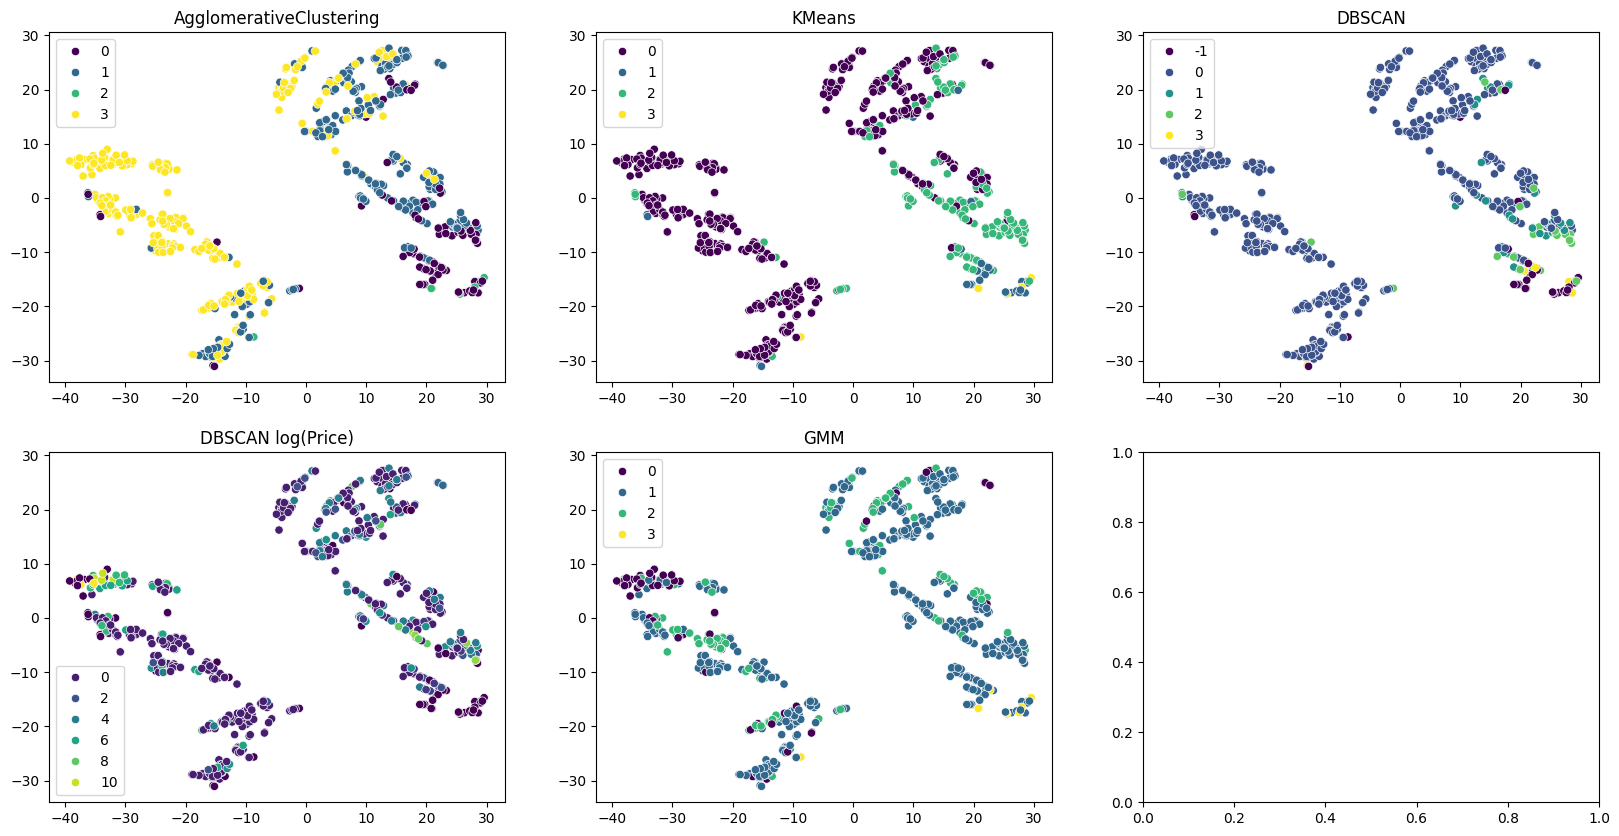

In [81]:
df1_copy = df1.copy()
df1_copy['Price'] = np.log(df1_copy['Price'] )
df1_copy['primary_storage_capacity'] = np.log2(df1.primary_storage_capacity)
df1_copy['secondary_storage_capacity'] = df1_copy['secondary_storage_capacity'].apply(lambda x : max(0,np.log2(x)))
df1_copy['resolution_width']  = np.log(df1_copy.resolution_width)
df1_copy['resolution_height'] = np.log(df1_copy.resolution_height) 

tSNE = TSNE(random_state=60, verbose=1,n_iter=1000)
digits_proj = tSNE.fit_transform(df1_copy)

figure,ax = plt.subplots(2,3,figsize=(20,10))
ax = ax.flatten()
predictions = [y_aggc,y_km,y_dbscan,y_dbscan_log,y_gmm]
predictions_title = ['AgglomerativeClustering','KMeans','DBSCAN','DBSCAN log(Price)','GMM']
for i in range(len(predictions)):
    sns.scatterplot(x=digits_proj[:,0], y=digits_proj[:,1],hue=predictions[i],palette='viridis',ax=ax[i])
    ax[i].set_title(predictions_title[i])
plt.show()

4. Rating -> do [0,1]

C:\Users\jancw\AppData\Local\Temp\ipykernel_4232\3805654617.py:4: RuntimeWarning: divide by zero encountered in log2
  df1_copy['secondary_storage_capacity'] = df1_copy['secondary_storage_capacity'].apply(lambda x : max(0,np.log2(x)))


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 693 samples in 0.000s...
[t-SNE] Computed neighbors for 693 samples in 0.039s...
[t-SNE] Computed conditional probabilities for sample 693 / 693
[t-SNE] Mean sigma: 1.585056
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.435921
[t-SNE] KL divergence after 1000 iterations: 0.153061


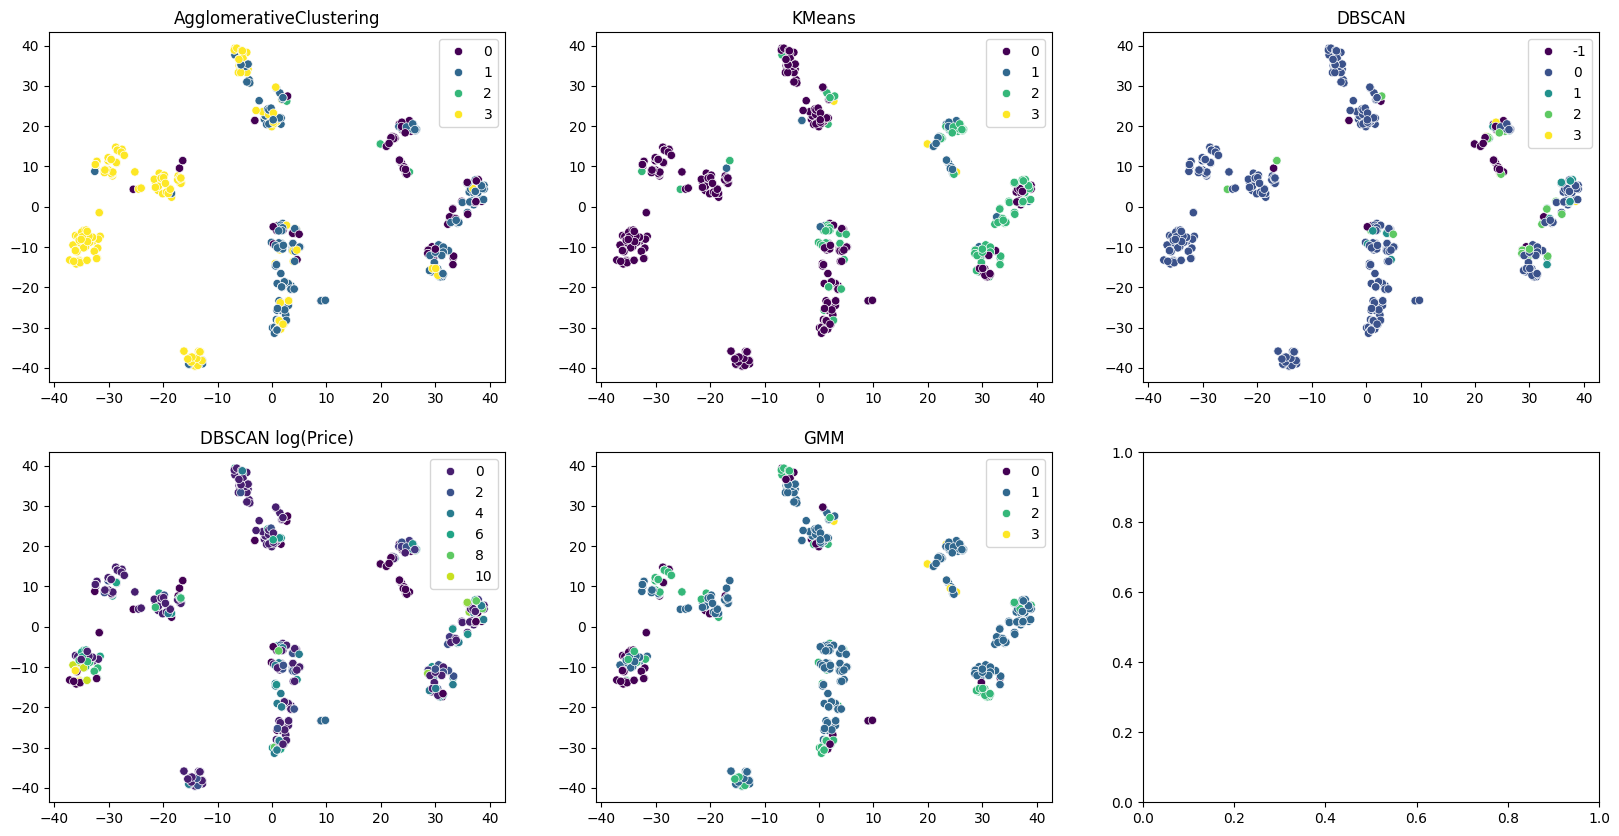

In [82]:
df1_copy = df1.copy()
df1_copy['Price'] = np.log(df1_copy['Price'] )
df1_copy['primary_storage_capacity'] = np.log2(df1.primary_storage_capacity)
df1_copy['secondary_storage_capacity'] = df1_copy['secondary_storage_capacity'].apply(lambda x : max(0,np.log2(x)))
df1_copy['resolution_width']  = np.log(df1_copy.resolution_width)
df1_copy['resolution_height'] = np.log(df1_copy.resolution_height) 
df1_copy['Rating'] = df1_copy['Rating']/100

tSNE = TSNE(random_state=60, verbose=1,n_iter=1000)
digits_proj = tSNE.fit_transform(df1_copy)

figure,ax = plt.subplots(2,3,figsize=(20,10))
ax = ax.flatten()
predictions = [y_aggc,y_km,y_dbscan,y_dbscan_log,y_gmm]
predictions_title = ['AgglomerativeClustering','KMeans','DBSCAN','DBSCAN log(Price)','GMM']
for i in range(len(predictions)):
    sns.scatterplot(x=digits_proj[:,0], y=digits_proj[:,1],hue=predictions[i],palette='viridis',ax=ax[i])
    ax[i].set_title(predictions_title[i])
plt.show()

5. display_size -> cos

<Axes: xlabel='display_size', ylabel='Count'>

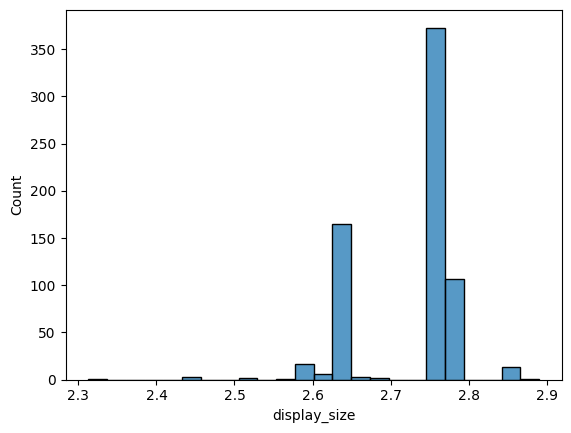

In [84]:
sns.histplot(np.log(df1.display_size))

C:\Users\jancw\AppData\Local\Temp\ipykernel_4232\1702082332.py:4: RuntimeWarning: divide by zero encountered in log2
  df1_copy['secondary_storage_capacity'] = df1_copy['secondary_storage_capacity'].apply(lambda x : max(0,np.log2(x)))


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 693 samples in 0.000s...
[t-SNE] Computed neighbors for 693 samples in 0.042s...
[t-SNE] Computed conditional probabilities for sample 693 / 693
[t-SNE] Mean sigma: 1.467401
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.811382
[t-SNE] KL divergence after 1000 iterations: 0.136357


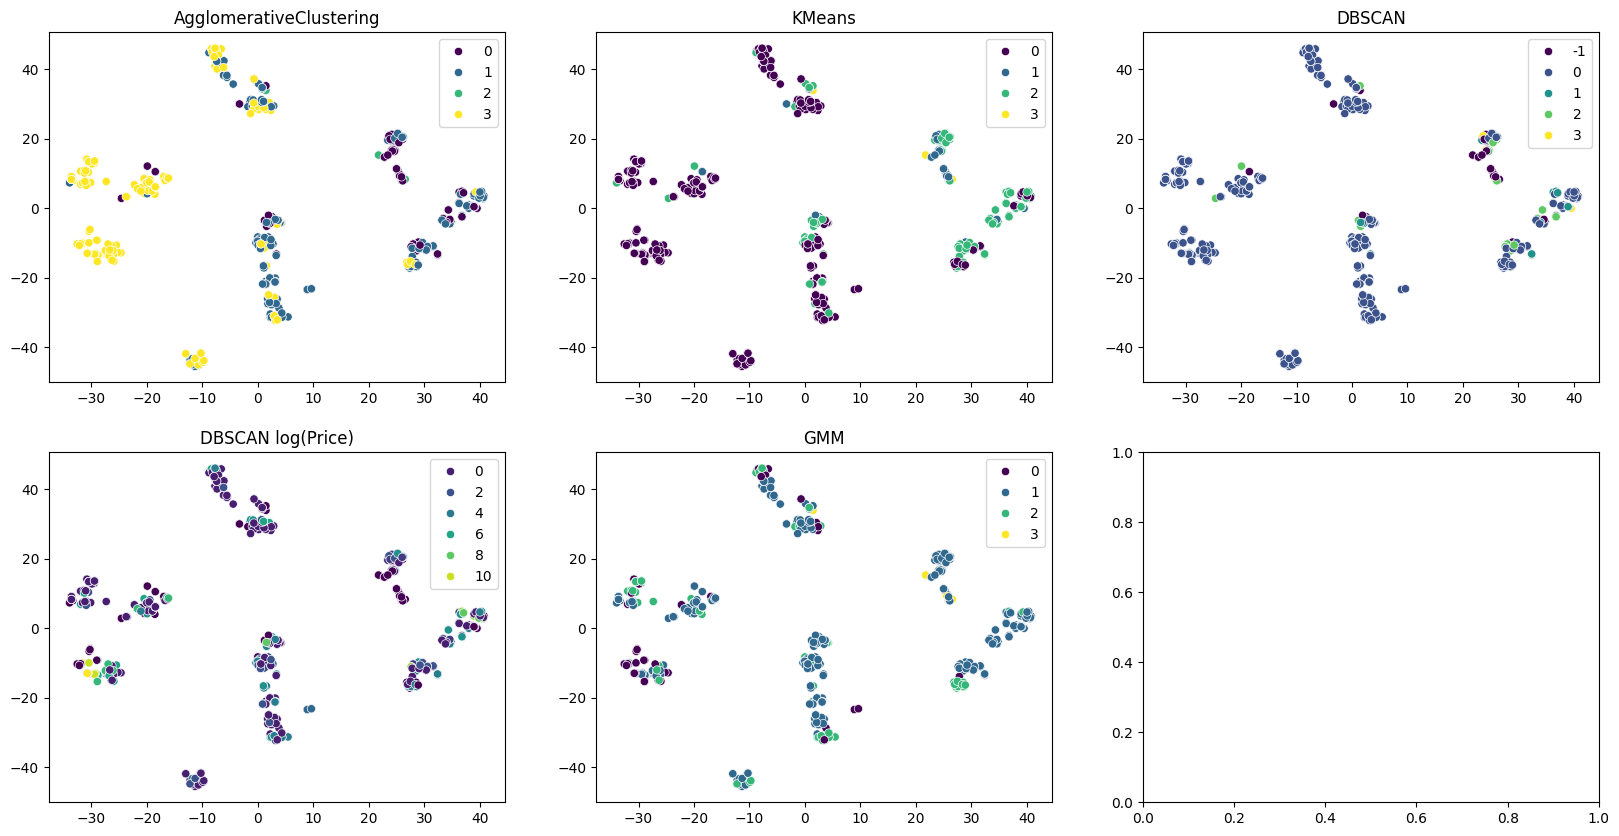

In [88]:
df1_copy = df1.copy()
df1_copy['Price'] = np.log(df1_copy['Price'] )
df1_copy['primary_storage_capacity'] = np.log2(df1.primary_storage_capacity)
df1_copy['secondary_storage_capacity'] = df1_copy['secondary_storage_capacity'].apply(lambda x : max(0,np.log2(x)))
df1_copy['resolution_width']  = np.log(df1_copy.resolution_width)
df1_copy['resolution_height'] = np.log(df1_copy.resolution_height) 
df1_copy['Rating'] = df1_copy['Rating']/100
df1_copy['display_size'] = (df1_copy['display_size']-min(df1_copy['display_size']))/(max(df1_copy['display_size'])-min(df1_copy['display_size']))

tSNE = TSNE(random_state=60, verbose=1,n_iter=1000)
digits_proj = tSNE.fit_transform(df1_copy)

figure,ax = plt.subplots(2,3,figsize=(20,10))
ax = ax.flatten()
predictions = [y_aggc,y_km,y_dbscan,y_dbscan_log,y_gmm]
predictions_title = ['AgglomerativeClustering','KMeans','DBSCAN','DBSCAN log(Price)','GMM']
for i in range(len(predictions)):
    sns.scatterplot(x=digits_proj[:,0], y=digits_proj[:,1],hue=predictions[i],palette='viridis',ax=ax[i])
    ax[i].set_title(predictions_title[i])
plt.show()

# Wszystkie kształty TSNE

In [ ]:
# def all_subsets(n):
#     lista = []



#     return lista

In [ ]:

# for i in range()
#     df1_copy = df1.copy()
#     df1_copy['Price'] = np.log(df1_copy['Price'] )
#     df1_copy['primary_storage_capacity'] = np.log2(df1.primary_storage_capacity)
#     df1_copy['secondary_storage_capacity'] = df1_copy['secondary_storage_capacity'].apply(lambda x : max(0,np.log2(x)))
#     df1_copy['resolution_width']  = np.log(df1_copy.resolution_width)
#     df1_copy['resolution_height'] = np.log(df1_copy.resolution_height) 
#     df1_copy['Rating'] = df1_copy['Rating']/100
#     df1_copy['display_size'] = (df1_copy['display_size']-min(df1_copy['display_size']))/(max(df1_copy['display_size'])-min(df1_copy['display_size']))

#     tSNE = TSNE(random_state=60, verbose=1,n_iter=1000)
#     digits_proj = tSNE.fit_transform(df1_copy)

#     figure,ax = plt.subplots(2,3,figsize=(20,10))
#     ax = ax.flatten()
#     predictions = [y_aggc,y_km,y_dbscan,y_dbscan_log,y_gmm]
#     predictions_title = ['AgglomerativeClustering','KMeans','DBSCAN','DBSCAN log(Price)','GMM']
#     for i in range(len(predictions)):
#         sns.scatterplot(x=digits_proj[:,0], y=digits_proj[:,1],hue=predictions[i],palette='viridis',ax=ax[i])
#         ax[i].set_title(predictions_title[i])
#     plt.show()